In [992]:
import numpy as np # linear algebra
import pandas as pd # rawprocessing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'): 
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [993]:
# import requirement libraries and tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.optim as optim
import torch.nn as nn
import torch.functional as F
# import plotly.graph_objects as go

from tqdm.notebook import tqdm
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import ExponentialLR
import warnings
warnings.filterwarnings("ignore")

from os.path import dirname, abspath
import sys, os
d = dirname(os.path.abspath(''))
sys.path.append(d)
# from implicitdl import ImplicitModel, ImplicitModelLoRA, ImplicitFunctionInf, ImplicitFunctionTriu, ImplicitRNNCell, ImplicitRNNCellLoRA
from implicitdl import *

In [994]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda:3") 
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")
torch.set_default_device(device)
generator = torch.Generator(device=device)

GPU is available


In [1233]:
import numpy as np
import matplotlib.pyplot as plt

generate_data = 0

input_dim_gt = 1
hidden_dim_gt = 3
output_dim_gt = 1

np.random.seed(0)

if generate_data:
    den = 5
    Agt = nn.Parameter(torch.randn(hidden_dim_gt, hidden_dim_gt)/den)
    Bgt = nn.Parameter(torch.randn(hidden_dim_gt, input_dim_gt))
    Cgt = nn.Parameter(torch.randn(output_dim_gt, hidden_dim_gt))
    Dgt = nn.Parameter(torch.randn(output_dim_gt, input_dim_gt))
    gt_model = ImplicitModel(hidden_dim_gt, input_dim_gt, output_dim_gt, f=ImplicitFunctionInf).eval()
    # initialize the model with the random matrices
    gt_model.A = Agt
    gt_model.B = Bgt
    gt_model.C = Cgt
    gt_model.D = Dgt

    # generate data for training and validation using gt_mode
    n_samples = 2000
    n_samples_val = 100
    x_values = torch.randn(n_samples, input_dim_gt)*10
    y_values = gt_model(x_values)
    x_values_val = torch.randn(n_samples_val, input_dim_gt)*10
    y_values_val = gt_model(x_values_val)
    # save the data to npz file
    np.savez(f'./kaggle/input/synthetic_fp_data_h{hidden_dim}.npz', x_values=x_values.detach().cpu(), y_values=y_values.detach().cpu(), x_values_val=x_values_val.detach().cpu(), y_values_val=y_values_val.detach().cpu())
    # print(x_values[:5], y_values[:5])

# load from the npz file
data = np.load(f'./kaggle/input/synthetic_fp_data_h{hidden_dim}.npz')
x_values = torch.tensor(data['x_values']).to(device)
y_values = torch.tensor(data['y_values']).to(device)
# print(x_values[:5], y_values[:5])
x_values_val = torch.tensor(data['x_values_val']).to(device)
y_values_val = torch.tensor(data['y_values_val']).to(device)
# into data_loader
training_set = TensorDataset(x_values, y_values)
validation_set = TensorDataset(x_values_val, y_values_val)

# Model

In [1234]:
from typing import Optional

class CustomInf(ImplicitFunctionInf):
    """
    Change the default convergence parameters.
    """
    mitr = grad_mitr = 500
    tol = grad_tol = 1e-6
    
def fuse_parameters(model):
    """Move model parameters to a contiguous tensor, and return that tensor."""
    n = sum(p.numel() for p in model.parameters())
    params = torch.zeros(n)
    i = 0
    for p in model.parameters():
        params_slice = params[i:i + p.numel()]
        params_slice.copy_(p.flatten())
        p.data = params_slice.view(p.shape)
        i += p.numel()
    return params

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_size, output_dim, act):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_size, bias=False),
            act(),
            nn.Linear(hidden_size, hidden_size, bias=False),
            act(),
            # nn.Linear(hidden_size, hidden_size, bias=False),
            # act(),
            nn.Linear(hidden_size, output_dim, bias=False),
        )
    def forward(self, x):
        x1 = x.flatten(1,-1)
        return self.model(x1)

# Define and train Model

In [1235]:
def train_one_epoch(model, training_loader, optimizer, scheduler, loss_fn):
    running_loss = 0.
    last_loss = 0.
    for t, data in enumerate(training_loader):
        x_train, y_train = data
        optimizer.zero_grad()
        y_train_pred = model(x_train)
        loss = loss_fn(y_train_pred, y_train)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if (t % 10 == 9):
            last_loss = running_loss / 10 # loss per batch
            running_loss = 0.
    return last_loss

def plot_hist(y_axis, xlabel, ylabel, title, x_axis=None, log=False):
    plt.figure()
    if (x_axis is None):
        x_axis = range(len(y_axis))
    if log:
        plt.semilogy(x_axis, y_axis)
    else:
        plt.plot(x_axis, y_axis)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.title(title, fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()


def evaluate_model(model, validation_loader):
    # Disable gradient computation and reduce memory consumption.
    running_vloss = 0.
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels).item()
            running_vloss += vloss
    avg_vloss = running_vloss / (i + 1)
    return avg_vloss

In [1236]:
lora_size = 1
hidden_size = 14
more_state = 2

# Build model
hidden_dim = 8 #15
num_layers = 2

make_imp = lambda: ImplicitModel(hidden_dim_gt, input_dim_gt, output_dim_gt, f=ImplicitFunctionInf, no_D=False, bias=False)
make_mlp = lambda: MLP(input_dim_gt, 3, output_dim_gt, act=nn.ReLU)

In [1241]:
batch_size = 64
EPOCHS = 30
RUNS = 1

# format data for training to dataloader
training_loader = DataLoader(training_set, batch_size=batch_size, shuffle=True, generator=generator)
validation_loader = DataLoader(validation_set, batch_size=batch_size, shuffle=True, generator=generator)
loss_fn = torch.nn.MSELoss()
generator = torch.Generator(device=device)

best_vloss = 1_000_000.
for run_idx in range(RUNS):
    # model, lr = make_mlp().to(device), 0.01; #torch.nn.init.normal_(fuse_parameters(model))
    model, lr = make_imp().to(device), 0.05; torch.nn.init.normal_(fuse_parameters(model), mean=0, std=0.1)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = ExponentialLR(optimizer, gamma=0.99)
    # print(model)
    if run_idx == 0:
        print(f'model size: {sum(p.numel() for p in model.parameters())} parameters')
    
    avg_vloss_all = []
    avg_loss_all = []
    for epoch in range(EPOCHS):
        model.train(True)    
        avg_loss = train_one_epoch(model, training_loader, optimizer, scheduler, loss_fn)
        avg_loss_all.append(avg_loss)
        scheduler.step()

        model.eval()
        avg_vloss = evaluate_model(model, validation_loader)
        avg_vloss_all.append(avg_vloss)
        print(f'Epoch {epoch} loss: {avg_loss}, val loss: {avg_vloss}')

        if avg_vloss < best_vloss:
            best_vloss = avg_vloss

# print(f'r2 (higher better):    {np.mean(r2s):.2f} +- {np.std(r2s):.2f}')
# print(f'MAPE (smaller better): {np.mean(mapes):.2f} +- {np.std(mapes):.2f}')
# ############# can calibrate size of RNN to compartible with imp_rnn
# best_r2_index = np.argmax(r2s)
# best_mape_index = np.argmin(mapes)

# print(f'Best r2 (higher better):    {r2s[best_r2_index]:.2f} at iteration {best_r2_index}')
# print(f'Best MAPE (smaller better): {mapes[best_mape_index]:.2f} at iteration {best_mape_index}')

model size: 195 parameters


Epoch 0 loss: 375.66113433837893, val loss: 328.0666046142578
Epoch 1 loss: 165.99893646240236, val loss: 134.98455047607422
Epoch 2 loss: 63.175590133666994, val loss: 62.485795974731445
Epoch 3 loss: 47.32434349060058, val loss: 50.5195369720459
Epoch 4 loss: 40.09423713684082, val loss: 35.71927070617676
Epoch 5 loss: 33.77985763549805, val loss: 30.13668155670166
Epoch 6 loss: 28.71887378692627, val loss: 24.85742473602295
Epoch 7 loss: 24.777446746826172, val loss: 22.304816246032715
Epoch 8 loss: 20.500851154327393, val loss: 18.20893383026123
Epoch 9 loss: 19.69402618408203, val loss: 20.41759967803955
Epoch 10 loss: 16.387354469299318, val loss: 14.65210247039795
Epoch 11 loss: 12.123310375213624, val loss: 11.802646160125732
Epoch 12 loss: 12.341010570526123, val loss: 10.347174644470215
Epoch 13 loss: 9.970420932769775, val loss: 8.56108283996582
Epoch 14 loss: 10.112753105163574, val loss: 7.973433971405029
Epoch 15 loss: 9.876246881484985, val loss: 7.403282880783081
Epoch 

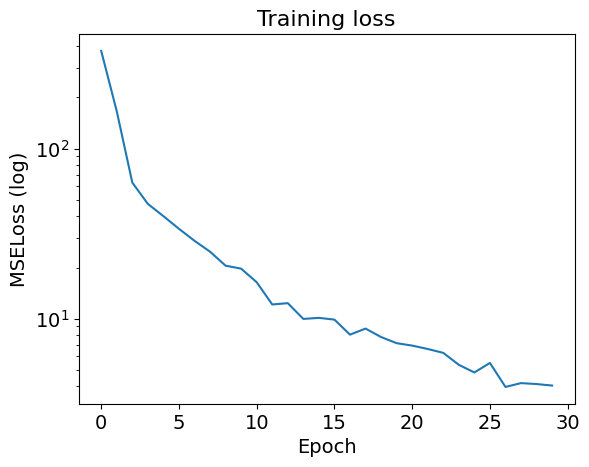

In [1242]:
plot_hist(avg_loss_all, 'Epoch', 'MSELoss (log)', 'Training loss', log=True)
plot_hist(avg_vloss_all, 'Epoch', 'MSELoss (log)', 'Validation loss', log=True)

In [ ]:
if isinstance(model, ImplicitModel):
    # compare model.A with gt_model.A
    # print(model.A.cpu().detach().numpy())
    print(gt_model.A.cpu().detach().numpy())
    # print(model.D.cpu().detach().numpy())
    # print(gt_model.D.cpu().detach().numpy())

    print((model.A - gt_model.A).norm().item())
    print((model.B - gt_model.B).norm().item())
    print((model.C - gt_model.C).norm().item())
    print((model.D - gt_model.D).norm().item())


In [ ]:
x_test = torch.randn(1, input_dim_gt)*10000
# x_test = x_values[np.random.randint(0, n_samples)].unsqueeze(0)
y_test = gt_model(x_test)
y_test_pred = model(x_test)
print(f'x_test: {x_test.item()}')
print(f'y_test: {y_test.item()}')
print(f'y_test_pred: {y_test_pred.item()}')

running_mape = 0.
with torch.no_grad():
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels = vdata
        voutputs = model(vinputs)
        mape = ((voutputs - vlabels).norm(dim=1) / vlabels.norm(dim=1)).mean()
        running_mape += mape
avg_mape = running_mape / (i + 1)
print(f'avg mape: {avg_mape}')

RuntimeError: a Tensor with 5 elements cannot be converted to Scalar

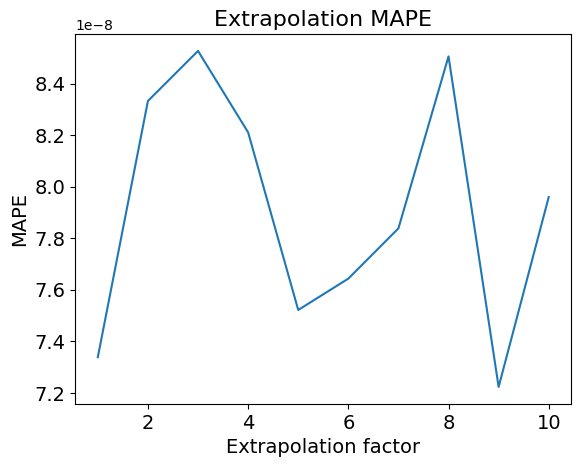

In [ ]:
extrap_level = 1
extrap_max = 10
mapes = []

with torch.no_grad():
    for ood_level in range(extrap_max):
        x_ood = torch.randn(n_samples_val, input_dim_gt)*10**extrap_level
        y_ood = gt_model(x_ood)
        y_ood_pred = model(x_ood)
        mape = ((y_ood - y_ood_pred).norm(dim=1) / y_ood_pred.norm(dim=1)).mean()
        mapes.append(mape.cpu())

# figure for mapes
plot_hist(mapes, 'Extrapolation factor', 'MAPE', 'Extrapolation MAPE', x_axis=range(1,extrap_max+1))
